Token features
1. cwc-min: ratio of (nos. of common words to the length of smaller question) 
2. cwc-max: ratio of (nos. of common words to the length of greater question) 
3. csc-min: ratio of (nos. of common stopwords to the length of stopwords of smaller question)
4. csc-max: ratio of (nos. of common stopwords to the length of stopwords of larger question)
5. ctc-min: ratio of (nos. of common tokens to the length of tokens of smaller question)
6. ctc-max: ratio of (nos. of common tokens to the length of tokens of larger question)
7. last_word_eq: last word of sentence should match
8. first_word_eq: first word of sentence should match

Length based features
1. mean_len: mean of the length of two questions(i.e. via tokens)
2. abs_len_diff
3. longest_substr_ratio

Fuzzy features(from FUZZYWUZZY)
1. fuzz_ratio
2. fuzz_partial_ratio
3. token_sort_ratio
4. token_set_ratio

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

In [49]:
df = pd.read_csv('train.csv')

In [50]:
new_df = df.sample(30000, random_state=2)

In [51]:
new_df.sample(5)

id    qid1    qid2  \
162905  162905  253517  253518   
42303    42303   76253   76254   
219071  219071  291054  325836   
193177  193177  104901    1270   
361520  361520  108950   60733   

                                                question1  \
162905  Why has China, a much larger country, never in...   
42303   What would it be like to be raised by two psyc...   
219071       What are some good books on Joseph Goebbels?   
193177  What is the best way to learn and practice C p...   
361520                    Why is Elon Musk so successful?   

                                                question2  is_duplicate  
162905     Why was Japan never invaded by China or Korea?             1  
42303   What is it like to have a high functioning psy...             0  
219071        What are the best books on Joseph Goebbels?             1  
193177  What are the good websites to learn C programm...             1  
361520            How did Elon Musk become so successful?             1

In [52]:
def preprocess(q):
    q=str(q).lower().strip()

    #replace certain special characters with their string equivalent
    q = q.replace('%','percent')
    q = q.replace('$','dollar')
    q = q.replace('₹','ruppe')
    q = q.replace('₹','rupee')
    q = q.replace('€','euro')
    q = q.replace('@','at')

    #the pattern '[math]' appears around 900 times in the whole dataset
    q = q.replace('[math]','')

    #replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000','b')
    q = q.replace(',000,000','m')
    q = q.replace(',000','k')
    q = re.sub(r'([0-9]+)000000000',r'\1b', q)
    q = re.sub(r'([0-9]+)000000',r'\1m', q)
    q = re.sub(r'([0-9]+)000',r'\1k', q)

    #decontracting words
    #https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
    #https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/19794953#19794953
    contractions = { 
    "ain't": "am not / are not / is not / has not / have not",
    "aren't": "are not / am not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had / he would",
    "he'd've": "he would have",
    "he'll": "he shall / he will",
    "he'll've": "he shall have / he will have",
    "he's": "he has / he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how has / how is / how does",
    "I'd": "I had / I would",
    "I'd've": "I would have",
    "I'll": "I shall / I will",
    "I'll've": "I shall have / I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it had / it would",
    "it'd've": "it would have",
    "it'll": "it shall / it will",
    "it'll've": "it shall have / it will have",
    "it's": "it has / it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she had / she would",
    "she'd've": "she would have",
    "she'll": "she shall / she will",
    "she'll've": "she shall have / she will have",
    "she's": "she has / she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as / so is",
    "that'd": "that would / that had",
    "that'd've": "that would have",
    "that's": "that has / that is",
    "there'd": "there had / there would",
    "there'd've": "there would have",
    "there's": "there has / there is",
    "they'd": "they had / they would",
    "they'd've": "they would have",
    "they'll": "they shall / they will",
    "they'll've": "they shall have / they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had / we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what shall / what will",
    "what'll've": "what shall have / what will have",
    "what're": "what are",
    "what's": "what has / what is",
    "what've": "what have",
    "when's": "when has / when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where has / where is",
    "where've": "where have",
    "who'll": "who shall / who will",
    "who'll've": "who shall have / who will have",
    "who's": "who has / who is",
    "who've": "who have",
    "why's": "why has / why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had / you would",
    "you'd've": "you would have",
    "you'll": "you shall / you will",
    "you'll've": "you shall have / you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve","have")
    q = q.replace("n't","not")
    q = q.replace("'re","are")
    q = q.replace("'ll","will")

    #removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()

    #remove punctuations
    pattern = re.compile('/W')
    q = re.sub(pattern, ' ', q).strip()

    return q

In [53]:
new_df['question1'] = new_df['question1'].apply(preprocess)
new_df['question2'] = new_df['question2'].apply(preprocess)

In [54]:
new_df.sample(5)

id    qid1    qid2  \
49226    49226   87635   87636   
384874  384874   67239  513327   
402739  402739  339787  536260   
41081    41081   74229   74230   
261003  261003  327601  377040   

                                                question1  \
49226                   what are the best fiction novels?   
384874                how do i keep a conversation going?   
402739              what is the right age to be a mother?   
41081   what are the variable costs paid to employees ...   
261003    what is the best gift for newly married couple?   

                                                question2  is_duplicate  
49226                      which are best fiction novels?             1  
384874               how can i keep a conversation going?             1  
402739          what is the right age to become a father?             0  
41081   what are some steps taken by indian it compani...             0  
261003  what are the best gifts for newly married coup...             1

In [55]:
#feature engineering
new_df['q1_len'] = new_df['question1'].str.len()
new_df['q2_len'] = new_df['question2'].str.len()

In [56]:
new_df['q1_num_words'] = new_df['question1'].apply(lambda row: len(row.split(" ")))
new_df['q2_num_words'] = new_df['question2'].apply(lambda row: len(row.split(" ")))
new_df.sample(5)

id    qid1    qid2  \
248069  248069  361422  361423   
204846  204846  235876  191525   
188681  188681  172794  159348   
322059  322059  118518  434750   
382342  382342  223549  514186   

                                                question1  \
248069                          how do i regrow eyebrows?   
204846     what is it like as an indian living in france?   
188681  what are some mind blowing insane technology i...   
322059         which is the best bollywood movie in 2015?   
382342  what do you do when you oversleep for work? ta...   

                                                question2  is_duplicate  \
248069                 how do i regrow eyelashes quickly?             0   
204846  what is it like to be an indian living in france?             1   
188681  what are some mind blowing inventions and tech...             1   
322059                what are the best bollywood movies?             0   
382342     how can one avoid oversleeping while studying?             0   

        q1_len  q2_len  q1_num_words  q2_num_words  
248069      25      34             5             6  
204846      46      49            10            11  
188681      84      90            13            16  
322059      42      35             8             6  
382342      62      46            12             7

In [57]:
# get common words
def common_words(row): #pura row pass kiya
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" "))) #ques1 k sare words
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" "))) #quest2 k sare words
    return len(w1 & w2) #intersection among the two

In [58]:
new_df['word_common'] = new_df.apply(common_words, axis=1)
new_df.sample(5)

id    qid1    qid2  \
236928  236928   84905   70549   
188918  188918  270047  287568   
393384  393384   42397   54381   
285157  285157  405524  405525   
55593    55593   97991   82222   

                                                question1  \
236928           how can i increase my typing speed fast?   
188918  how do death metal singers growl without damag...   
393384                   how one can deal with a breakup?   
285157  some videos in you tube tell us that nasa is l...   
55593             what does intercourse feel like to men?   

                                                question2  is_duplicate  \
236928                 how do i increase my typing speed?             1   
188918  can you name any great musician who criticized...             0   
393384                       how do i get over a breakup?             1   
285157  is it better to say "the best is yet to come",...             0   
55593                        how does sex feel for a man?             1   

        q1_len  q2_len  q1_num_words  q2_num_words  word_common  
236928      40      34             8             7            5  
188918      62      96            10            17            1  
393384      32      28             7             7            3  
285157     114     104            26            21            4  
55593       39      28             7             7            2

In [59]:
def total_words(row): #pura row pass kiya
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" "))) #ques1 k sare words
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" "))) #quest2 k sare words
    return (len(w1) + len(w2)) #intersection among the two

In [60]:
new_df['word_total'] = new_df.apply(total_words, axis=1)
new_df.sample(5)

id    qid1    qid2  \
396148  396148  529192  529193   
65211    65211  113204  113205   
31727    31727   58474   58475   
208564  208564  312594   32021   
78485    78485  133820  133821   

                                                question1  \
396148           would it be possible to build barad-dûr?   
65211   what happens when a person who takes an educat...   
31727     how do i find investors for my medical startup?   
208564  what is a good solar panel installation provid...   
78485        why do we get bored with it after few years?   

                                                question2  is_duplicate  \
396148  what is the best way to find the actual height...             0   
65211   what happens when a personal who took a person...             1   
31727       how can i find investors for my tech startup?             1   
208564  what is a good solar panel installation provid...             0   
78485   why do i get bored of something after a few we...             0   

        q1_len  q2_len  q1_num_words  q2_num_words  word_common  word_total  
396148      40      93             7            19            1          24  
65211       62      59            11            11            7          20  
31727       47      45             9             9            7          18  
208564      76      75            12            12           11          24  
78485       44      84            10            17            6          27

In [61]:
new_df['word_share'] = round(new_df['word_common']/new_df['word_total'],2)
new_df.sample(5)

id    qid1    qid2  \
303549  303549  426705  426706   
400604  400604  518996  364131   
169526  169526  262326  262327   
302827  302827  425859  425860   
4140      4140    8191    8192   

                                                question1  \
303549             what is cylindrical coordinate system?   
400604  what was cvs health's ipo price? what would 10...   
169526             how did burhan wani's family view him?   
302827     does immigration overseas have any complaints?   
4140      how do i prepare for neet in the last 6 months?   

                                                question2  is_duplicate  \
303549  what is the difference between the cylindrical...             0   
400604  what was symantec's ipo price? what would 100 ...             0   
169526  what is the social media reaction to the death...             0   
302827       how do i file a complaint in consumer forum?             0   
4140          how do i prepare for neet 2017 in 6 months?             1   

        q1_len  q2_len  q1_num_words  q2_num_words  word_common  word_total  \
303549      38      93             5            13            5          16   
400604      70      68            13            12           10          23   
169526      38      62             7            12            1          18   
302827      46      44             6             9            0          15   
4140        47      43            11            10            9          21   

        word_share  
303549        0.31  
400604        0.43  
169526        0.06  
302827        0.00  
4140          0.43

Advanced Features

In [63]:
#token based features
from nltk.corpus import stopwords

def fetch_token_features(row):
    q1 = row['question1']
    q2 = row['question2']

    SAFE_DIV = 0.0001

    STOP_WORDS = stopwords.words("english")

    token_features = [0.0]*8 #8 zeroes

    #converting the sentences to tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) ==0:
        return token_features

    #get the non-stopwords in questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    #get the stopwords in questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

    #get the common non-stopwords from the question pair
    common_word_count = len(q1_words.intersection(q2_words))

    #get the common stopwords from the question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))

    #get the common tokens from the question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

    #last word of both questions are same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

    #first word of both the questions are same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])

    return token_features

In [64]:
token_features = new_df.apply(fetch_token_features, axis=1)

new_df['cwc_min'] = list(map(lambda x: x[0], token_features))
new_df['cwc_max'] = list(map(lambda x: x[1], token_features))
new_df['csc_min'] = list(map(lambda x: x[2], token_features))
new_df['csc_max'] = list(map(lambda x: x[3], token_features))
new_df['ctc_min'] = list(map(lambda x: x[4], token_features))
new_df['ctc_max'] = list(map(lambda x: x[5], token_features))
new_df['last_word_eq'] = list(map(lambda x: x[6], token_features))
new_df['first_word_eq'] = list(map(lambda x: x[7], token_features))


In [65]:
new_df.sample(5)

id    qid1    qid2  \
363664  363664  493665  493666   
258066  258066  373515  373516   
107189  107189   18172    1215   
252223  252223  366509  366510   
270105  270105  387924   30782   

                                                question1  \
363664            is designcrowd’s online job believable?   
258066  did the union army enslave tens of thousands o...   
107189  what are the prophecies of world war 3 and wil...   
252223            what are your favorite hip hop ad libs?   
270105  pornography law: is it legal to distribute por...   

                                                question2  is_duplicate  \
363664                        are online jobs believable?             0   
258066               does this post have any truth to it?             0   
107189        is world war 3 more imminent than expected?             1   
252223  is the life of an animal worth less than a hum...             0   
270105  how can you look at someone's private instagra...             0   

        q1_len  q2_len  q1_num_words  q2_num_words  ...  word_total  \
363664      39      27             5             4  ...           9   
258066      90      36            15             8  ...          22   
107189      67      43            13             8  ...          21   
252223      39     112             8            25  ...          29   
270105     117      79            17            12  ...          29   

        word_share   cwc_min   cwc_max  csc_min  csc_max   ctc_min   ctc_max  \
363664        0.22  0.666644  0.666644      0.0      0.0  0.499988  0.499988   
258066        0.00  0.000000  0.000000      0.0      0.0  0.000000  0.000000   
107189        0.14  0.599988  0.599988      0.0      0.0  0.374995  0.374995   
252223        0.00  0.000000  0.000000      0.0      0.0  0.000000  0.000000   
270105        0.00  0.000000  0.000000      0.0      0.0  0.000000  0.000000   

        last_word_eq  first_word_eq  
363664             1              0  
258066             0              0  
107189             0              0  
252223             0              0  
270105             0              0  

[5 rows x 21 columns]

In [66]:
pip install textdistance


Note: you may need to restart the kernel to use updated packages.


In [67]:
#length based features

def fetch_length_features(row):

    q1 = row['question1']
    q2 = row['question2']

    length_features = [0.0]*3

    #converting the sentence into tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features

    #Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))

    #average token length of both the questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2

    import textdistance

    def lcsubstring(q1, q2):
        substrings = textdistance.lcsstr(q1, q2)
        return list(substrings)

    return length_features

In [68]:
length_features = new_df.apply(fetch_length_features, axis=1)

new_df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
new_df['mean_len'] = list(map(lambda x: x[1], length_features))
new_df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [69]:
#fuzzy features
!pip install fuzzywuzzy

In [70]:
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']

    fuzzy_features = [0.0]*4

    #fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    #fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    #fuzz_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    #token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [71]:
fuzzy_features = new_df.apply(fetch_fuzzy_features, axis=1)

new_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
new_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
new_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
new_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [72]:
print(new_df.shape)
new_df.sample(5)

(30000, 28)


id    qid1    qid2  \
284579  284579   49313  153522   
269249  269249   57751   56779   
72375    72375  124372  124373   
48152    48152    6919   85890   
371570  371570   29328   23405   

                                                question1  \
284579  what are career option and job opportunities f...   
269249  will we get more and more dark energy and vacu...   
72375   what are the best ways to use dollar100 amazon...   
48152   what is the definition of 'levity' and how is ...   
371570              how can i write an essay efficiently?   

                                                question2  is_duplicate  \
284579  what are some job opportunities for a mechanic...             1   
269249  is dark energy and vacuum energy potential ene...             1   
72375   what is the best way to use a hmv gift card on...             0   
48152   what is the definition of "dilemma"? how is it...             0   
371570                       how do i write a good essay?             1   

        q1_len  q2_len  q1_num_words  q2_num_words  ...   ctc_max  \
284579     102      69            14            11  ...  0.727266   
269249     102      59            18             9  ...  0.444440   
72375       57      51            11            12  ...  0.545450   
48152       68      66            14            13  ...  0.769225   
371570      37      28             7             7  ...  0.428565   

        last_word_eq  first_word_eq  abs_len_diff  mean_len  \
284579             1              1             3      12.5   
269249             0              0             9      13.5   
72375              0              1             1      11.5   
48152              1              1             1      13.5   
371570             0              1             0       7.0   

        longest_substr_ratio  fuzz_ratio  fuzz_partial_ratio  \
284579                   0.0          75                  77   
269249                   0.0          53                  68   
72375                    0.0          74                  69   
48152                    0.0          89                  85   
371570                   0.0          63                  71   

        token_sort_ratio  token_set_ratio  
284579                79               87  
269249                56               67  
72375                 68               77  
48152                 80               90  
371570                63               77  

[5 rows x 28 columns]

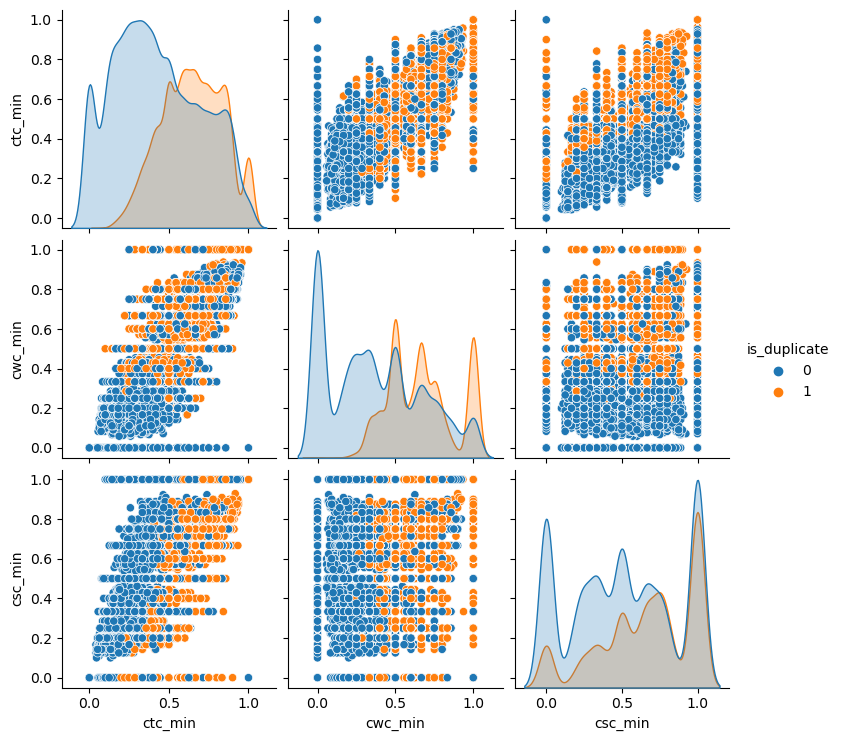

In [73]:
sns.pairplot(new_df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']], hue='is_duplicate')

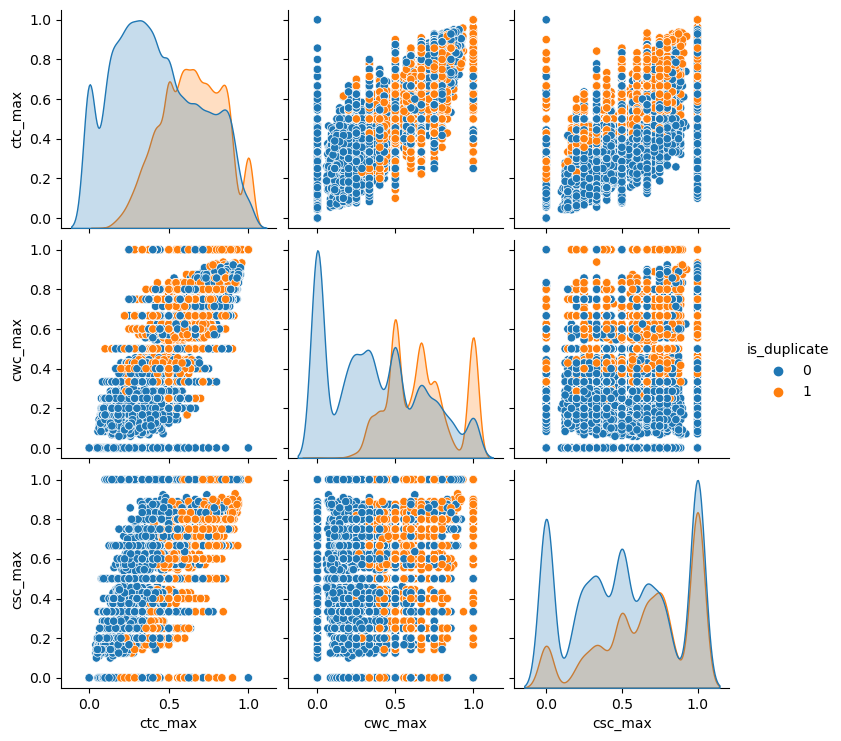

In [74]:
sns.pairplot(new_df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']], hue='is_duplicate')

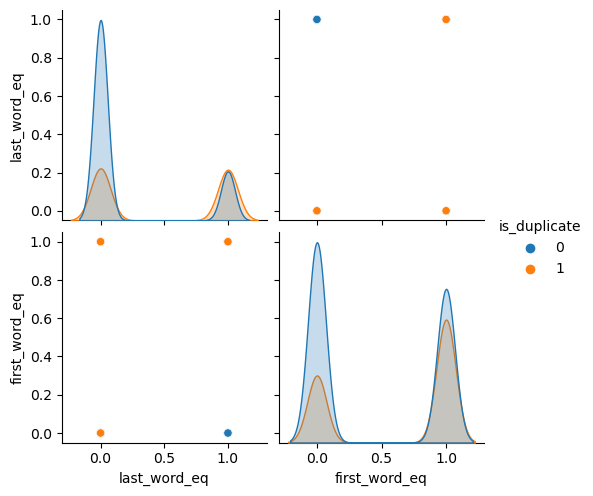

In [75]:
sns.pairplot(new_df[['last_word_eq', 'first_word_eq', 'is_duplicate']], hue='is_duplicate')

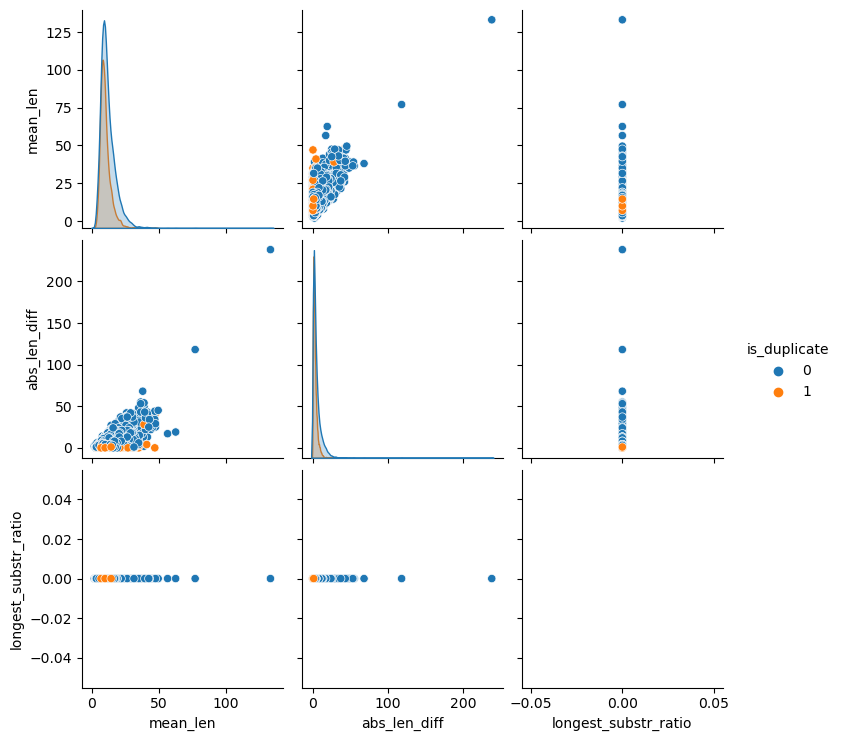

In [76]:
sns.pairplot(new_df[['mean_len', 'abs_len_diff', 'longest_substr_ratio', 'is_duplicate']], hue='is_duplicate')

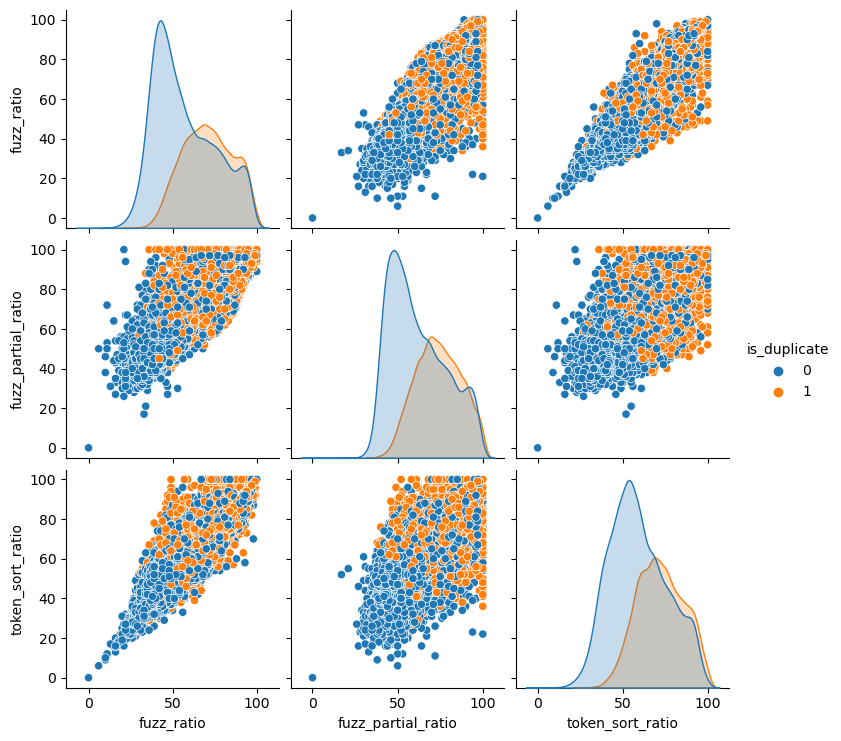

In [77]:
sns.pairplot(new_df[['fuzz_ratio', 'fuzz_partial_ratio', 'token_sort_ratio', 'is_duplicate']], hue='is_duplicate')

In [78]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(new_df[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = new_df['is_duplicate'].values

In [79]:
from sklearn.manifold import TSNE

tsne2d = TSNE(
        n_components=3,
        init='random', # pca
        random_state=101,
        method='barnes_hut',
        n_iter=1000,
        verbose=2,
        angle=0.5
    ).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.084s...
[t-SNE] Computed neighbors for 30000 samples in 4.529s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sam

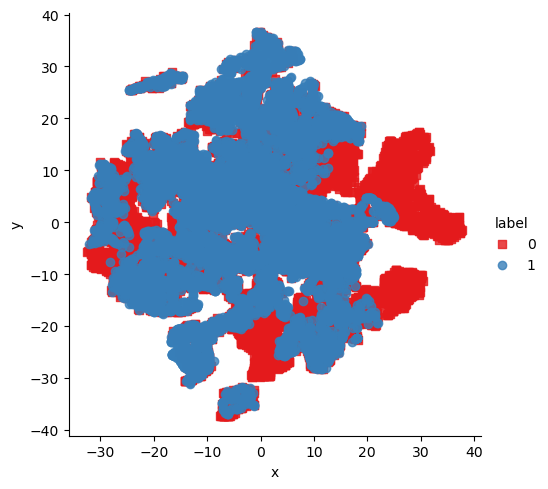

In [80]:
x_df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=x_df, x='x', y='y', hue='label', fit_reg=False,  palette="Set1",markers=['s','o'])

In [81]:
#for 3D plot

tsne3d = TSNE(

    n_components=3,
    
    init='random', # pca
    
    random_state=101,
    
    method='barnes_hut',
    
    n_iter=1000,
    
    verbose=2,
    
    angle=0.5

).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.075s...
[t-SNE] Computed neighbors for 30000 samples in 4.471s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sam

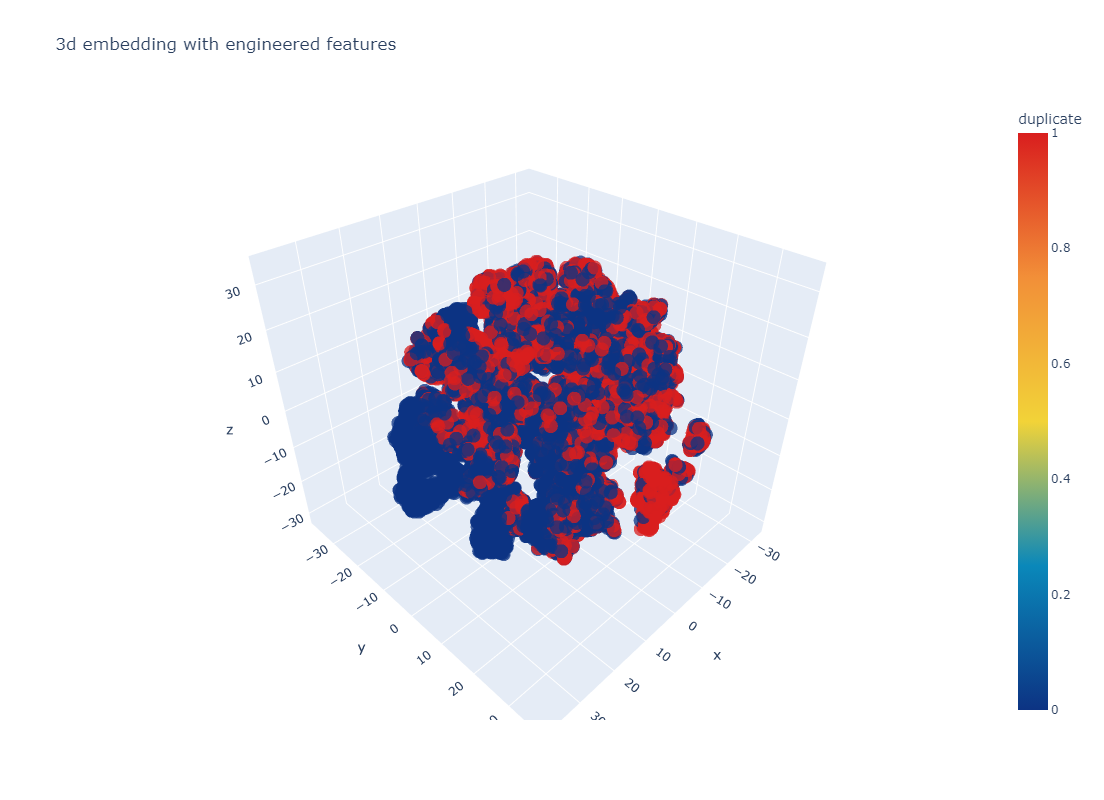

In [82]:
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.offline as py
py.init_notebook_mode(connected=True)

trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

In [83]:
ques_df = new_df[['question1','question2']]
ques_df.sample(5)

question1  \
323506                are there any limits to friendship?   
224002  what are the most important things which i sho...   
11695            how is corn meal the same as corn flour?   
199461    will trump have to release his tax returns now?   
335529                       do you think cnn is corrupt?   

                                               question2  
323506                 is there any limit to friendship?  
224002              what is the golden age of kali yuga?  
11695               is corn flour the same as corn meal?  
199461  will trump ever have to release his tax returns?  
335529                                   is cnn corrupt?

In [84]:
final_df = new_df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.sample(5)

(30000, 23)


is_duplicate  q1_len  q2_len  q1_num_words  q2_num_words  word_common  \
246660             0      56      85            11            14            3   
76810              0     112     117            21            22            6   
17267              0      57      33            11             7            6   
108325             0      84      41            15             7            1   
23647              1      32      28             7             6            3   

        word_total  word_share   cwc_min   cwc_max  ...   ctc_max  \
246660          24        0.12  0.166664  0.166664  ...  0.272725   
76810           36        0.17  0.333330  0.333330  ...  0.285713   
17267           18        0.33  0.999967  0.999967  ...  0.857131   
108325          21        0.05  0.000000  0.000000  ...  0.142855   
23647           13        0.23  0.333322  0.333322  ...  0.499992   

        last_word_eq  first_word_eq  abs_len_diff  mean_len  \
246660             0              0             3      12.5   
76810              0              1             1      21.5   
17267              1              1             4       9.0   
108325             0              1             8      11.0   
23647              0              1             1       6.5   

        longest_substr_ratio  fuzz_ratio  fuzz_partial_ratio  \
246660                   0.0          45                  46   
76810                    0.0          59                  59   
17267                    0.0          70                  67   
108325                   0.0          39                  44   
23647                    0.0          59                  61   

        token_sort_ratio  token_set_ratio  
246660                49               51  
76810                 54               64  
17267                 70               95  
108325                39               41  
23647                 55               59  

[5 rows x 23 columns]

In [85]:
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features=5000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)


In [86]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(30000, 10000)

In [87]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.sample(5)

(30000, 10023)


is_duplicate  q1_len  q2_len  q1_num_words  q2_num_words  word_common  \
309254             0      81      24            16             5            2   
69587              0      85      76            14            12            5   
68816              0     112     113            19            19           17   
103789             0     124      49            22            12            3   
83902              0      33      19             6             4            2   

        word_total  word_share   cwc_min   cwc_max  ...  4990  4991  4992  \
309254          21        0.10  0.499975  0.499975  ...     0     0     0   
69587           25        0.20  0.333328  0.333328  ...     0     0     0   
68816           36        0.47  0.888879  0.888879  ...     0     0     0   
103789          30        0.10  0.249994  0.249994  ...     0     0     0   
83902           10        0.20  0.000000  0.000000  ...     0     0     0   

        4993  4994  4995  4996  4997  4998  4999  
309254     0     0     0     0     0     0     0  
69587      0     0     0     0     0     0     0  
68816      0     0     0     0     0     0     0  
103789     0     0     0     0     0     0     0  
83902      0     0     0     0     0     0     0  

[5 rows x 10023 columns]

In [88]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)


0.7878333333333334

In [90]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)
accuracy_score(y_test,y_pred1)


0.7975

In [91]:
from sklearn.metrics import confusion_matrix

In [92]:
# for random forest model we would use this as type 2 error is less
confusion_matrix(y_test,y_pred)

array([[3182,  630],
       [ 643, 1545]], dtype=int64)

In [93]:
# for xgboost model
confusion_matrix(y_test,y_pred1)

array([[3147,  665],
       [ 550, 1638]], dtype=int64)

In [94]:
def test_common_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return len(w1 & w2)

In [95]:
def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return (len(w1) + len(w2))

In [96]:
def test_fetch_token_features(q1,q2):
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

    # Last word of both questions are same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both questions are same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [97]:
def test_fetch_length_features(q1,q2):
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2

    def lcsubstring(q1, q2):
        strs = list(textdistance.lcsstr(q1, q2))
        length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
        return list(strs)

    
    return length_features

In [98]:
def test_fetch_fuzzy_features(q1,q2):
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [99]:
def query_point_creator(q1,q2):
    
    input_query = []
    
    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)
    
    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))
    
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    
    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))
    
    # fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)
    
    # fetch length based features
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)
    
    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)
    
    # bow feature for q1
    q1_bow = cv.transform([q1]).toarray()
    
    # bow feature for q2
    q2_bow = cv.transform([q2]).toarray()
    return np.hstack((np.array(input_query).reshape(1,22),q1_bow,q2_bow))

In [100]:
#to check the performance of model
q1 = 'Where is the capital of India?'
q2 = 'What is the current capital of Pakistan?'
q3 = 'Which city serves as the capital of India?'
q4 = 'What is the business capital of India?'

In [101]:
rf1 = rf.predict(query_point_creator(q1,q4))
rf2 = rf.predict(query_point_creator(q1,q2))

In [102]:
cv

CountVectorizer(max_features=5000)

In [103]:
import pickle

pickle.dump(rf,open('model.pkl','wb'))
pickle.dump(cv,open('cv.pkl','wb'))

In [163]:
import pickle
from nltk.corpus import stopwords
import nltk

# Download the stopwords dataset if not already present
nltk.download('stopwords')

# Get the English stopwords
stop_words = stopwords.words("english")

# Save the stopwords to a pickle file
with open('stopwords.pkl', 'wb') as f:
    pickle.dump(stop_words, f)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
